# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
from IPython.display import HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

In [0]:
np.random.seed(0)

# Data Generation

In [4]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


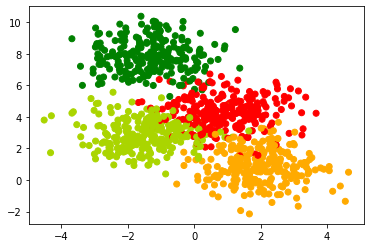

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

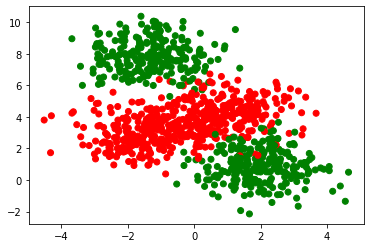

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

# Preparing Data

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [10]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


# Class for Vectorized FFN

In [0]:
class VFFN:

    def __init__(self, W1, W2):
        self.W1 = W1.copy()
        self.W2 = W2.copy()
        self.B1 = np.zeros((1,2))
        self.B2 = np.zeros((1,4))

    def sigmoid(self, X):
        return 1.0/(1.0 + np.exp(-X))

    def softmax(self, X):
        exps = np.exp(X)
        return exps/np.sum(exps, axis=1).reshape(-1,1)

    def forward_pass(self, X):
        self.A1 = np.matmul(X, self.W1) + self.B1
        self.H1 = self.sigmoid(self.A1)
        self.A2 = np.matmul(self.H1, self.W2) + self.B2
        self.H2 = self.softmax(self.A2)
        return self.H2

    def grad_sigmoid(self, X):
        return X*(1-X)

    def grad(self, X, Y):
        self.forward_pass(X)
        m = X.shape[0]

        self.dA2 = self.H2-Y

        self.dW2 = np.matmul(self.H1.T, self.dA2)
        self.dB2 = np.sum(self.dA2, axis=0).reshape(1,-1)
        self.dH1 = np.matmul(self.dA2, self.W2.T)
        self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1))
        self.dW1 = np.matmul(X.T, self.dA1)
        self.dB1 = np.sum(self.dA1, axis=0).reshape(1,-1)

    def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):

        if display_loss:
            loss = {}
        
        for i in tqdm(range(epochs), total=epochs, unit='epoch'):
            self.grad(X,Y)

            m=X.shape[0]
            self.W2 -= learning_rate * (self.dW2/m)
            self.B2 -= learning_rate * (self.dB2/m)
            self.W1 -= learning_rate * (self.dW1/m)
            self.B1 -= learning_rate * (self.dB1/m)

            if display_loss:
                Y_pred = self.predict(X)
                loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
        
        if display_loss:
            plt.plot(np.array(list(loss.values())).astype(np.float))
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()

    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

# Using Vectorized FFN for Classification

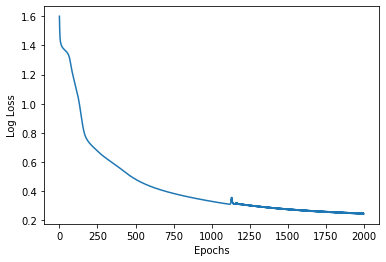

In [12]:
vffn = VFFN(W1, W2)
vffn.fit(X_train, y_OH_train, epochs=2000, learning_rate=0.5, display_loss=True)

In [13]:
Y_pred_train = vffn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train, 1)

Y_pred_val = vffn.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val, 1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)

print("Training Accuracy: ", round(accuracy_train,2))
print("Validation Accuracy: ", round(accuracy_val,2))

Training Accuracy:  0.92
Validation Accuracy:  0.94


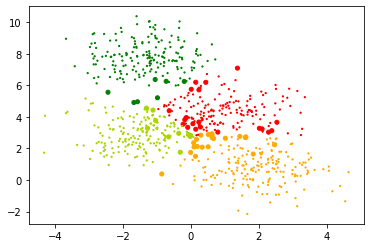

In [14]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+0.1))
plt.show()